<a href="https://colab.research.google.com/github/signLangProjectNIC/tf-cnn-lstm4/blob/main/tf_cnn_lstm17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#here we are going to experiment with LSTM regularisation
'''
for 0.3 l2 of CNN3D
I still suspect a little overfitting
So here we are going to solve that using lstm regularization
'''

'\nfor 0.3 l2 of CNN3D\nI still suspect a little overfitting\nSo here we are going to solve that using lstm regularization\n'

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1


BaseException: ignored

In [ ]:
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from moviepy.editor import *
import cv2
import moviepy
import sys
import tensorflow.keras.layers as tfKL
from tensorflow.keras import regularizers
from keras.layers import Activation, Dense 
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import random
import pandas as pd
nLookback=4
nSubsequences= 5
height=50
width=50
channels=3
nCategories=8
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
X=np.load("/content/gdrive/MyDrive/hand sign database array X.npy")
Y=np.load("/content/gdrive/MyDrive/hand sign database array Y.npy")
Xmean=np.mean(X)
Xstd=np.std(X)
print(Xmean)
print(Xstd)
X=(X-Xmean)/Xstd
nCategories=8
Xmean=np.mean(X)
Xstd=np.std(X)
print(Xmean)
print(Xstd)
trainSetX=list()
testSetX=list()
trainSetY=list()
testSetY=list()
valSetX=list()
valSetY=list()
for i in range(nCategories):
  wholeset=list()
  for j in range(np.shape(Y)[0]):
    if(Y[j]==i):
      wholeset.append(j)
  # idk=X[wholeset]
  print(np.shape(wholeset))
  traini,testnvali=train_test_split(wholeset,test_size=0.25)
  vali,testi=train_test_split(testnvali,test_size=(10/35))
  for x in traini:
    trainSetX.append(X[x])
    trainSetY.append(Y[x])
  for x in testi:
    testSetX.append(X[x])
    testSetY.append(Y[x])
  for x in vali:
    valSetX.append(X[x])
    valSetY.append(Y[x])
print(np.shape(trainSetX))
print(np.shape(valSetX))
print(np.shape(testSetX))

76.08792970149254
37.221323957827764
-7.58063079786192e-17
0.9999999999999996
(52,)
(52,)
(52,)
(52,)
(52,)
(40,)
(52,)
(50,)
(301, 20, 50, 50, 3)
(70, 20, 50, 50, 3)
(31, 20, 50, 50, 3)


In [ ]:
def createModel(layers,metrics=['accuracy'],loss='categorical_crossentropy',optimizer='adam'):
  with tpu_strategy.scope():
    model=tf.keras.Sequential()
    for layer in layers:
      model.add(layer)
    model.compile(metrics=metrics,loss=loss,optimizer=optimizer)    
    return model

In [ ]:
def evaluateModel(layers,trainX=trainSetX,trainY=trainSetY,valX=valSetX,valY=valSetY,metrics=['accuracy'],loss='categorical_crossentropy',optimizer='adam',nSubsequences=5,nLookback=4,nCategories=8,verbose=2,epochs=500,batch_size=10):
  
  with tpu_strategy.scope(): 
    trainX=np.asarray(trainX)
    trainY=np.asarray(trainY)
    valX=np.asarray(valX)
    valY=np.asarray(valY)
    height=trainX.shape[2]
    width=trainX.shape[3]
    channels=trainX.shape[4]
    trainX=trainX.reshape((trainX.shape[0],nSubsequences,nLookback,trainX.shape[2],trainX.shape[3],trainX.shape[4]))
    trainY=tf.keras.utils.to_categorical(trainY)

    
    valX=valX.reshape((valX.shape[0],nSubsequences,nLookback,valX.shape[2],valX.shape[3],valX.shape[4]))
    valY=tf.keras.utils.to_categorical(valY)
  print(np.shape(trainX))
  print(np.shape(trainY))
  print(np.shape(valX))
  print(np.shape(valY))
  with tpu_strategy.scope():
    model=createModel(layers=layers,metrics=metrics,loss=loss,optimizer=optimizer)
    # print(trainX)
    history=model.fit(x=trainX,y=trainY,batch_size=batch_size,epochs=epochs,verbose=verbose,validation_data =(valX,valY))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
  return model

In [ ]:
def testAccuracy(Result=Result,testSetY=testSetY):
  diff=np.asarray(Result)-np.asarray(testSetY)
  answer=(((np.shape(diff))[0]-np.count_nonzero(diff)))/(np.shape(diff)[0])
  return answer

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 17s - loss: 9.0113 - accuracy: 0.3090 - val_loss: 5.4523 - val_accuracy: 0.3571
Epoch 2/500
31/31 - 3s - loss: 3.9507 - accuracy: 0.5316 - val_loss: 3.0376 - val_accuracy: 0.4857
Epoch 3/500
31/31 - 3s - loss: 2.5607 - accuracy: 0.6213 - val_loss: 2.3765 - val_accuracy: 0.6286
Epoch 4/500
31/31 - 3s - loss: 2.2535 - accuracy: 0.6944 - val_loss: 2.3056 - val_accuracy: 0.6714
Epoch 5/500
31/31 - 3s - loss: 2.1346 - accuracy: 0.7243 - val_loss: 1.8720 - val_accuracy: 0.7571
Epoch 6/500
31/31 - 3s - loss: 1.6313 - accuracy: 0.7608 - val_loss: 1.7623 - val_accuracy: 0.7571
Epoch 7/500
31/31 - 3s - loss: 1.4069 - accuracy: 0.7608 - val_loss: 1.5403 - val_accuracy: 0.7143
Epoch 8/500
31/31 - 3s - loss: 1.3760 - accuracy: 0.7907 - val_loss: 1.5208 - val_accuracy: 0.7571
Epoch 9/500
31/31 - 3s - loss: 1.3053 - accuracy: 0.8140 - val_loss: 1.5559 - val_accuracy: 0.7429
Epoch 10/500
31/31 - 3s - loss: 1.2852 - accur

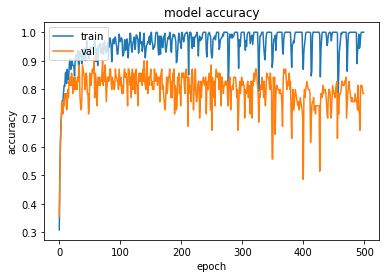

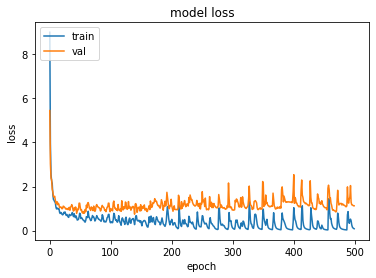

 Our result:- 
 [0 5 0 0 6 7 3 1 2 2 2 2 3 3 3 3 4 4 4 4 4 5 5 6 6 6 6 7 3 7 1]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]


TypeError: ignored

In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.3)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=100,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy())

In [ ]:
print(Result)

[0 5 0 0 6 7 3 1 2 2 2 2 3 3 3 3 4 4 4 4 4 5 5 6 6 6 6 7 3 7 1]


In [ ]:
print(" Our result:- \n",Result)
print("Real testY:- \n",testSetY)
print("Accuracy:- \n",testAccuracy())

 Our result:- 
 [0 5 0 0 6 7 3 1 2 2 2 2 3 3 3 3 4 4 4 4 4 5 5 6 6 6 6 7 3 7 1]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.7741935483870968


(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 18s - loss: 8.0454 - accuracy: 0.3455 - val_loss: 4.8383 - val_accuracy: 0.4714
Epoch 2/500
31/31 - 3s - loss: 3.9031 - accuracy: 0.4983 - val_loss: 3.4765 - val_accuracy: 0.4429
Epoch 3/500
31/31 - 3s - loss: 2.9608 - accuracy: 0.5914 - val_loss: 2.5616 - val_accuracy: 0.6571
Epoch 4/500
31/31 - 3s - loss: 2.4289 - accuracy: 0.6246 - val_loss: 2.2539 - val_accuracy: 0.6286
Epoch 5/500
31/31 - 3s - loss: 1.8954 - accuracy: 0.6910 - val_loss: 1.8374 - val_accuracy: 0.8000
Epoch 6/500
31/31 - 3s - loss: 1.7229 - accuracy: 0.7542 - val_loss: 1.8857 - val_accuracy: 0.6857
Epoch 7/500
31/31 - 3s - loss: 1.9367 - accuracy: 0.7143 - val_loss: 1.8761 - val_accuracy: 0.6857
Epoch 8/500
31/31 - 3s - loss: 1.8497 - accuracy: 0.7342 - val_loss: 2.4163 - val_accuracy: 0.7286
Epoch 9/500
31/31 - 3s - loss: 1.9382 - accuracy: 0.7641 - val_loss: 1.6765 - val_accuracy: 0.7571
Epoch 10/500
31/31 - 3s - loss: 1.1747 - accur

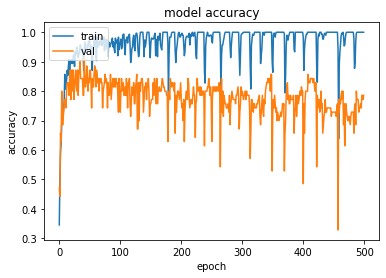

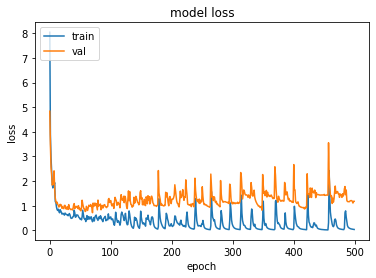

 Our result:- 
 [0 0 0 0 1 7 3 1 2 2 2 2 3 3 5 3 4 4 4 4 4 0 5 5 6 6 6 7 3 7 7]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.7741935483870968


In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.2)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=100,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy())

In [ ]:
print(Result)
print(testSetY)
print(testAccuracy(Result,testSetY))

[0 0 0 0 1 7 3 1 2 2 2 2 3 3 5 3 4 4 4 4 4 0 5 5 6 6 6 7 3 7 7]
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
0.7741935483870968


(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 17s - loss: 7.8599 - accuracy: 0.2326 - val_loss: 4.6534 - val_accuracy: 0.4714
Epoch 2/500
31/31 - 3s - loss: 3.7920 - accuracy: 0.4352 - val_loss: 3.1620 - val_accuracy: 0.5714
Epoch 3/500
31/31 - 3s - loss: 3.0724 - accuracy: 0.5615 - val_loss: 3.3933 - val_accuracy: 0.4143
Epoch 4/500
31/31 - 3s - loss: 3.1902 - accuracy: 0.5017 - val_loss: 3.0246 - val_accuracy: 0.6286
Epoch 5/500
31/31 - 3s - loss: 2.9675 - accuracy: 0.5183 - val_loss: 3.0701 - val_accuracy: 0.4714
Epoch 6/500
31/31 - 3s - loss: 2.7828 - accuracy: 0.5216 - val_loss: 2.6752 - val_accuracy: 0.6143
Epoch 7/500
31/31 - 3s - loss: 2.4362 - accuracy: 0.5648 - val_loss: 2.4746 - val_accuracy: 0.5714
Epoch 8/500
31/31 - 3s - loss: 2.4272 - accuracy: 0.5947 - val_loss: 2.4695 - val_accuracy: 0.6571
Epoch 9/500
31/31 - 3s - loss: 2.2731 - accuracy: 0.6777 - val_loss: 2.4466 - val_accuracy: 0.6000
Epoch 10/500
31/31 - 3s - loss: 2.2689 - accur

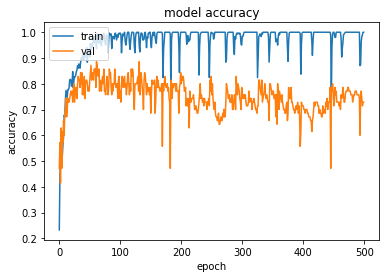

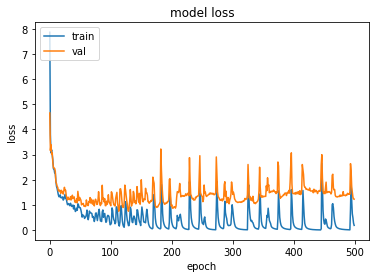

 Our result:- 
 [0 0 5 0 1 7 1 1 2 2 2 2 3 3 0 3 4 4 4 4 4 5 5 1 4 6 6 7 7 7 7]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.8064516129032258


In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=100,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy(Result,testSetY))

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 17s - loss: 8.9696 - accuracy: 0.2292 - val_loss: 4.9583 - val_accuracy: 0.4143
Epoch 2/500
31/31 - 3s - loss: 3.7169 - accuracy: 0.4817 - val_loss: 2.8049 - val_accuracy: 0.4857
Epoch 3/500
31/31 - 3s - loss: 2.2707 - accuracy: 0.6279 - val_loss: 2.2093 - val_accuracy: 0.7000
Epoch 4/500
31/31 - 3s - loss: 1.9094 - accuracy: 0.7076 - val_loss: 1.8961 - val_accuracy: 0.6571
Epoch 5/500
31/31 - 3s - loss: 1.8018 - accuracy: 0.7409 - val_loss: 1.8349 - val_accuracy: 0.7000
Epoch 6/500
31/31 - 3s - loss: 1.5191 - accuracy: 0.7475 - val_loss: 1.4866 - val_accuracy: 0.7714
Epoch 7/500
31/31 - 3s - loss: 1.4659 - accuracy: 0.7841 - val_loss: 1.5582 - val_accuracy: 0.8143
Epoch 8/500
31/31 - 4s - loss: 1.2924 - accuracy: 0.7973 - val_loss: 1.3149 - val_accuracy: 0.7714
Epoch 9/500
31/31 - 3s - loss: 1.0654 - accuracy: 0.8140 - val_loss: 1.1903 - val_accuracy: 0.8000
Epoch 10/500
31/31 - 3s - loss: 0.9800 - accur

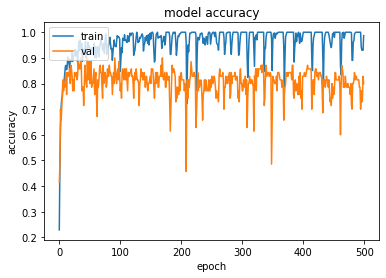

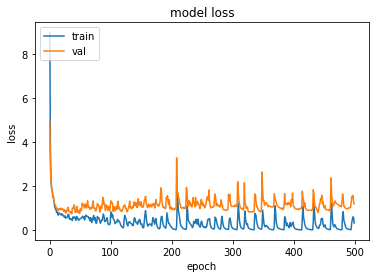

 Our result:- 
 [0 0 0 0 1 7 2 1 2 2 2 2 3 3 2 3 4 4 4 4 4 5 5 6 6 6 6 7 7 7 1]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.8387096774193549


In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.4)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=100,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy(Result,testSetY))

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 19s - loss: 11.1356 - accuracy: 0.3322 - val_loss: 5.6815 - val_accuracy: 0.5429
Epoch 2/500
31/31 - 5s - loss: 3.8627 - accuracy: 0.5814 - val_loss: 2.7494 - val_accuracy: 0.6429
Epoch 3/500
31/31 - 5s - loss: 2.2196 - accuracy: 0.7276 - val_loss: 2.1816 - val_accuracy: 0.7000
Epoch 4/500
31/31 - 5s - loss: 1.9651 - accuracy: 0.7010 - val_loss: 2.1260 - val_accuracy: 0.7286
Epoch 5/500
31/31 - 5s - loss: 1.9695 - accuracy: 0.7110 - val_loss: 2.1216 - val_accuracy: 0.8000
Epoch 6/500
31/31 - 5s - loss: 1.9521 - accuracy: 0.7608 - val_loss: 1.7990 - val_accuracy: 0.7857
Epoch 7/500
31/31 - 5s - loss: 1.6387 - accuracy: 0.7973 - val_loss: 2.0140 - val_accuracy: 0.6857
Epoch 8/500
31/31 - 5s - loss: 1.7303 - accuracy: 0.7874 - val_loss: 2.0459 - val_accuracy: 0.8714
Epoch 9/500
31/31 - 5s - loss: 1.6145 - accuracy: 0.7907 - val_loss: 1.6133 - val_accuracy: 0.7286
Epoch 10/500
31/31 - 5s - loss: 1.3691 - accu

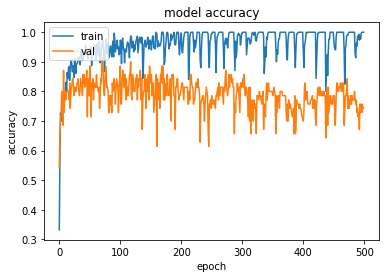

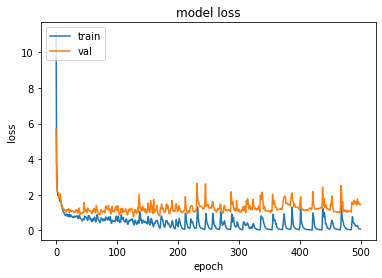

 Our result:- 
 [0 5 3 0 1 7 1 1 2 2 2 2 3 3 3 3 4 4 4 4 4 5 5 6 1 6 6 7 3 7 7]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.8064516129032258


In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.4)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=160,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy(Result,testSetY))

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 19s - loss: 5.9716 - accuracy: 0.3754 - val_loss: 3.5897 - val_accuracy: 0.6000
Epoch 2/500
31/31 - 3s - loss: 2.8229 - accuracy: 0.6013 - val_loss: 2.3927 - val_accuracy: 0.6857
Epoch 3/500
31/31 - 3s - loss: 2.0169 - accuracy: 0.6678 - val_loss: 2.1033 - val_accuracy: 0.7000
Epoch 4/500
31/31 - 3s - loss: 2.2209 - accuracy: 0.6346 - val_loss: 2.5310 - val_accuracy: 0.5429
Epoch 5/500
31/31 - 3s - loss: 2.3798 - accuracy: 0.6578 - val_loss: 2.4017 - val_accuracy: 0.6429
Epoch 6/500
31/31 - 3s - loss: 2.0455 - accuracy: 0.7043 - val_loss: 2.3174 - val_accuracy: 0.6286
Epoch 7/500
31/31 - 3s - loss: 1.9752 - accuracy: 0.6977 - val_loss: 1.9104 - val_accuracy: 0.6714
Epoch 8/500
31/31 - 3s - loss: 1.6159 - accuracy: 0.7243 - val_loss: 1.8096 - val_accuracy: 0.7429
Epoch 9/500
31/31 - 3s - loss: 1.4793 - accuracy: 0.7508 - val_loss: 1.5114 - val_accuracy: 0.7286
Epoch 10/500
31/31 - 3s - loss: 1.4998 - accur

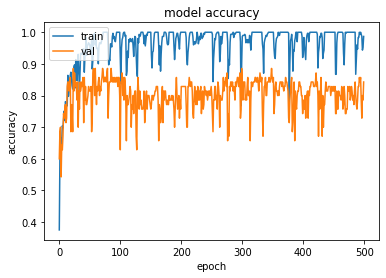

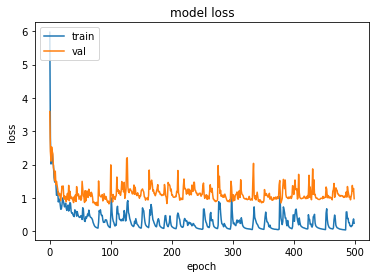

 Our result:- 
 [0 0 3 0 1 7 2 1 2 2 2 2 3 3 3 3 4 4 4 4 4 5 5 1 6 6 6 7 3 7 7]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.8064516129032258


In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.4)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=70,activation='tanh',trainable=True,return_sequences=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.LSTM(units=70,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy(Result,testSetY))

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 18s - loss: 8.7278 - accuracy: 0.2591 - val_loss: 4.4886 - val_accuracy: 0.5000
Epoch 2/500
31/31 - 3s - loss: 3.3342 - accuracy: 0.5648 - val_loss: 2.9966 - val_accuracy: 0.6143
Epoch 3/500
31/31 - 3s - loss: 2.5153 - accuracy: 0.6179 - val_loss: 2.1672 - val_accuracy: 0.7429
Epoch 4/500
31/31 - 3s - loss: 2.0597 - accuracy: 0.7010 - val_loss: 2.1441 - val_accuracy: 0.7429
Epoch 5/500
31/31 - 3s - loss: 2.0559 - accuracy: 0.7508 - val_loss: 2.0699 - val_accuracy: 0.7000
Epoch 6/500
31/31 - 3s - loss: 1.8846 - accuracy: 0.7209 - val_loss: 1.8598 - val_accuracy: 0.7571
Epoch 7/500
31/31 - 4s - loss: 1.7306 - accuracy: 0.7309 - val_loss: 1.9097 - val_accuracy: 0.6000
Epoch 8/500
31/31 - 3s - loss: 1.5793 - accuracy: 0.7508 - val_loss: 1.4499 - val_accuracy: 0.7714
Epoch 9/500
31/31 - 3s - loss: 1.1325 - accuracy: 0.8106 - val_loss: 1.2228 - val_accuracy: 0.7429
Epoch 10/500
31/31 - 3s - loss: 1.0175 - accur

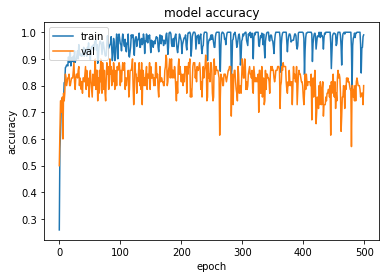

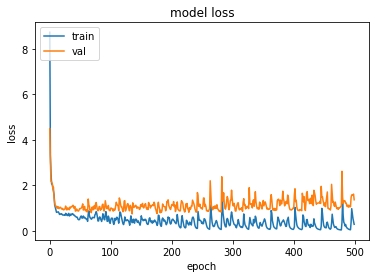

 Our result:- 
 [0 5 0 0 1 7 2 1 2 2 2 2 3 3 3 3 4 4 4 4 4 5 5 1 1 6 6 7 7 7 7]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.8064516129032258


In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.5)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=100,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy(Result,testSetY))

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 19s - loss: 24.8465 - accuracy: 0.4385 - val_loss: 6.9990 - val_accuracy: 0.5571
Epoch 2/500
31/31 - 5s - loss: 4.8823 - accuracy: 0.6146 - val_loss: 3.8552 - val_accuracy: 0.5857
Epoch 3/500
31/31 - 5s - loss: 3.2875 - accuracy: 0.6179 - val_loss: 3.0551 - val_accuracy: 0.6000
Epoch 4/500
31/31 - 5s - loss: 2.6842 - accuracy: 0.6711 - val_loss: 3.0092 - val_accuracy: 0.5714
Epoch 5/500
31/31 - 5s - loss: 2.7433 - accuracy: 0.6678 - val_loss: 2.5573 - val_accuracy: 0.6571
Epoch 6/500
31/31 - 5s - loss: 2.3694 - accuracy: 0.6678 - val_loss: 2.7037 - val_accuracy: 0.6429
Epoch 7/500
31/31 - 5s - loss: 2.3364 - accuracy: 0.7143 - val_loss: 2.3394 - val_accuracy: 0.7429
Epoch 8/500
31/31 - 5s - loss: 2.2082 - accuracy: 0.6977 - val_loss: 2.4002 - val_accuracy: 0.7286
Epoch 9/500
31/31 - 5s - loss: 2.0937 - accuracy: 0.7342 - val_loss: 2.1287 - val_accuracy: 0.7571
Epoch 10/500
31/31 - 5s - loss: 1.8227 - accu

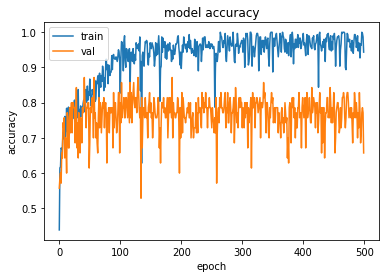

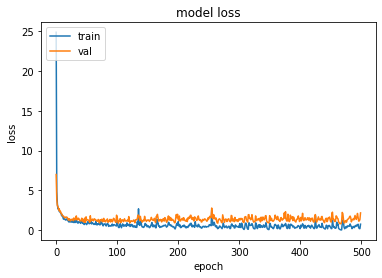

 Our result:- 
 [0 0 6 5 1 7 3 1 2 2 3 3 3 3 3 3 4 4 4 4 4 4 5 6 6 6 3 0 7 7 7]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.6774193548387096


In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.4)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=160,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.1)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy(Result,testSetY))

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 19s - loss: 16.4047 - accuracy: 0.3754 - val_loss: 7.6125 - val_accuracy: 0.5571
Epoch 2/500
31/31 - 3s - loss: 5.4700 - accuracy: 0.5914 - val_loss: 3.9525 - val_accuracy: 0.6286
Epoch 3/500
31/31 - 3s - loss: 3.1357 - accuracy: 0.6312 - val_loss: 2.6352 - val_accuracy: 0.6857
Epoch 4/500
31/31 - 3s - loss: 2.3810 - accuracy: 0.6512 - val_loss: 2.6476 - val_accuracy: 0.6286
Epoch 5/500
31/31 - 3s - loss: 2.2488 - accuracy: 0.6213 - val_loss: 2.4901 - val_accuracy: 0.5571
Epoch 6/500
31/31 - 3s - loss: 2.0107 - accuracy: 0.6811 - val_loss: 1.9359 - val_accuracy: 0.6571
Epoch 7/500
31/31 - 3s - loss: 1.9595 - accuracy: 0.6412 - val_loss: 2.4633 - val_accuracy: 0.5571
Epoch 8/500
31/31 - 3s - loss: 1.9720 - accuracy: 0.6412 - val_loss: 1.8923 - val_accuracy: 0.7429
Epoch 9/500
31/31 - 3s - loss: 1.7894 - accuracy: 0.6844 - val_loss: 1.6743 - val_accuracy: 0.7429
Epoch 10/500
31/31 - 3s - loss: 1.3268 - accu

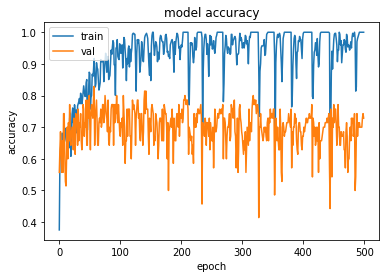

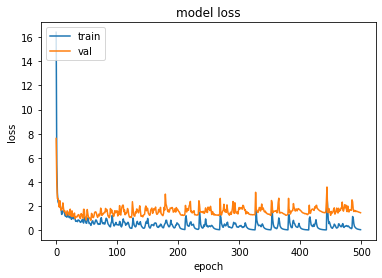

 Our result:- 
 [0 5 0 0 1 5 2 1 2 2 2 2 3 3 4 3 4 4 4 4 4 0 5 5 4 6 6 7 2 7 4]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.6774193548387096


In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.4)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=70,activation='tanh',trainable=True,return_sequences=True,kernel_regularizer=regularizers.l2(l2=0.08)))
layers.append(tfKL.LSTM(units=70,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.08)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy(Result,testSetY))

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 20s - loss: 2.7342 - accuracy: 0.3488 - val_loss: 1.8650 - val_accuracy: 0.5286
Epoch 2/500
31/31 - 3s - loss: 1.3963 - accuracy: 0.5748 - val_loss: 1.2846 - val_accuracy: 0.6143
Epoch 3/500
31/31 - 3s - loss: 0.9780 - accuracy: 0.6545 - val_loss: 0.9338 - val_accuracy: 0.7000
Epoch 4/500
31/31 - 3s - loss: 0.8182 - accuracy: 0.6844 - val_loss: 0.9758 - val_accuracy: 0.6857
Epoch 5/500
31/31 - 3s - loss: 0.7795 - accuracy: 0.6944 - val_loss: 1.0326 - val_accuracy: 0.6143
Epoch 6/500
31/31 - 3s - loss: 0.7384 - accuracy: 0.7176 - val_loss: 0.7535 - val_accuracy: 0.7714
Epoch 7/500
31/31 - 3s - loss: 0.6082 - accuracy: 0.7641 - val_loss: 0.8143 - val_accuracy: 0.7429
Epoch 8/500
31/31 - 3s - loss: 0.7636 - accuracy: 0.7143 - val_loss: 0.9874 - val_accuracy: 0.6714
Epoch 9/500
31/31 - 3s - loss: 0.7275 - accuracy: 0.7608 - val_loss: 0.8527 - val_accuracy: 0.8000
Epoch 10/500
31/31 - 3s - loss: 0.6648 - accur

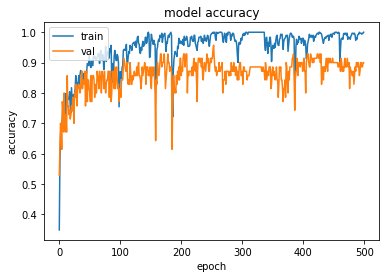

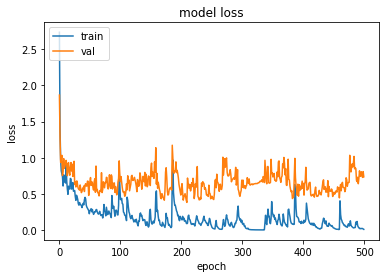

 Our result:- 
 [0 0 0 0 1 7 3 1 2 2 2 2 3 3 3 3 4 4 4 4 4 5 5 5 6 6 6 7 3 7 7]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.7741935483870968


In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.3)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=100,activation='tanh',trainable=True,return_sequences=True))
layers.append(tfKL.LSTM(units=100,activation='tanh',trainable=True))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy())

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 18s - loss: 2.6563 - accuracy: 0.3987 - val_loss: 1.8890 - val_accuracy: 0.5000
Epoch 2/500
31/31 - 2s - loss: 1.5437 - accuracy: 0.5548 - val_loss: 1.3543 - val_accuracy: 0.5286
Epoch 3/500
31/31 - 2s - loss: 1.1691 - accuracy: 0.5748 - val_loss: 1.1605 - val_accuracy: 0.6714
Epoch 4/500
31/31 - 2s - loss: 0.9746 - accuracy: 0.6379 - val_loss: 1.1099 - val_accuracy: 0.7000
Epoch 5/500
31/31 - 2s - loss: 0.8631 - accuracy: 0.6777 - val_loss: 1.2482 - val_accuracy: 0.6143
Epoch 6/500
31/31 - 2s - loss: 0.8346 - accuracy: 0.7475 - val_loss: 1.1210 - val_accuracy: 0.6429
Epoch 7/500
31/31 - 2s - loss: 0.7560 - accuracy: 0.7641 - val_loss: 1.1138 - val_accuracy: 0.7143
Epoch 8/500
31/31 - 2s - loss: 0.8810 - accuracy: 0.6910 - val_loss: 1.0235 - val_accuracy: 0.6857
Epoch 9/500
31/31 - 2s - loss: 0.7603 - accuracy: 0.7375 - val_loss: 0.9707 - val_accuracy: 0.7000
Epoch 10/500
31/31 - 2s - loss: 0.7461 - accur

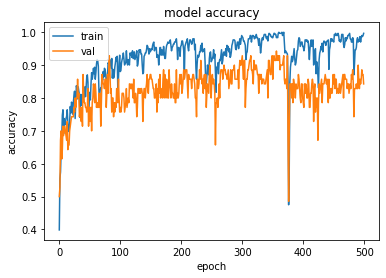

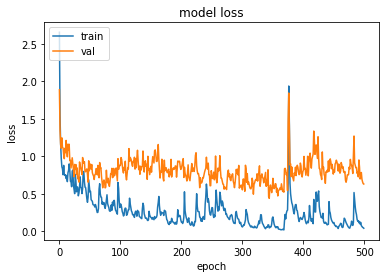

 Our result:- 
 [0 2 0 0 1 7 1 1 2 2 2 2 3 3 4 3 4 4 4 4 4 5 5 1 1 6 6 7 3 7 7]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.7741935483870968


In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.3)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=50,activation='tanh',trainable=True,return_sequences=True))
layers.append(tfKL.LSTM(units=50,activation='tanh',trainable=True))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy())

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 19s - loss: 2.8045 - accuracy: 0.3256 - val_loss: 1.9115 - val_accuracy: 0.5000
Epoch 2/500
31/31 - 3s - loss: 1.5099 - accuracy: 0.5382 - val_loss: 1.3183 - val_accuracy: 0.5429
Epoch 3/500
31/31 - 3s - loss: 1.0343 - accuracy: 0.6811 - val_loss: 1.3387 - val_accuracy: 0.5571
Epoch 4/500
31/31 - 4s - loss: 0.9598 - accuracy: 0.6578 - val_loss: 1.3181 - val_accuracy: 0.4857
Epoch 5/500
31/31 - 3s - loss: 1.0125 - accuracy: 0.6047 - val_loss: 1.0880 - val_accuracy: 0.5857
Epoch 6/500
31/31 - 3s - loss: 0.8213 - accuracy: 0.7076 - val_loss: 1.0442 - val_accuracy: 0.6714
Epoch 7/500
31/31 - 3s - loss: 0.8986 - accuracy: 0.6877 - val_loss: 1.0490 - val_accuracy: 0.7143
Epoch 8/500
31/31 - 3s - loss: 0.9159 - accuracy: 0.6811 - val_loss: 1.1372 - val_accuracy: 0.6857
Epoch 9/500
31/31 - 3s - loss: 0.8945 - accuracy: 0.7076 - val_loss: 0.9935 - val_accuracy: 0.7000
Epoch 10/500
31/31 - 3s - loss: 0.7319 - accur

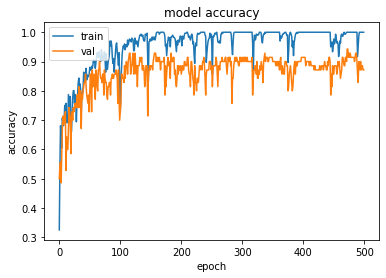

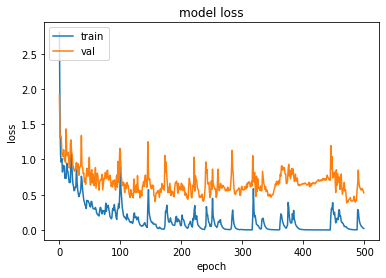

 Our result:- 
 [0 0 0 0 1 7 1 1 2 2 2 2 1 3 5 3 4 4 4 4 4 5 5 1 6 6 1 7 7 7 7]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.7741935483870968


In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.3)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=100,activation='tanh',trainable=True,return_sequences=True))
layers.append(tfKL.LSTM(units=50,activation='tanh',trainable=True))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy())

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 18s - loss: 2.7155 - accuracy: 0.3588 - val_loss: 1.9135 - val_accuracy: 0.4429
Epoch 2/500
31/31 - 2s - loss: 1.4034 - accuracy: 0.5947 - val_loss: 1.1438 - val_accuracy: 0.6429
Epoch 3/500
31/31 - 3s - loss: 0.9618 - accuracy: 0.6445 - val_loss: 1.2363 - val_accuracy: 0.6286
Epoch 4/500
31/31 - 2s - loss: 0.9472 - accuracy: 0.6811 - val_loss: 1.1785 - val_accuracy: 0.5429
Epoch 5/500
31/31 - 2s - loss: 0.9584 - accuracy: 0.6478 - val_loss: 1.0919 - val_accuracy: 0.5857
Epoch 6/500
31/31 - 2s - loss: 0.8597 - accuracy: 0.6777 - val_loss: 1.1560 - val_accuracy: 0.6714
Epoch 7/500
31/31 - 2s - loss: 0.8582 - accuracy: 0.6977 - val_loss: 1.1524 - val_accuracy: 0.6286
Epoch 8/500
31/31 - 2s - loss: 0.8592 - accuracy: 0.6944 - val_loss: 0.9894 - val_accuracy: 0.7429
Epoch 9/500
31/31 - 2s - loss: 0.7470 - accuracy: 0.7209 - val_loss: 1.0776 - val_accuracy: 0.6143
Epoch 10/500
31/31 - 2s - loss: 0.7490 - accur

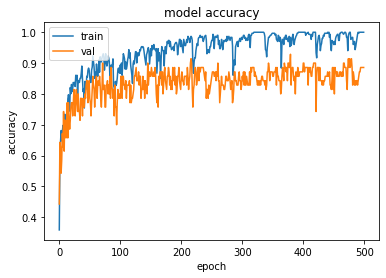

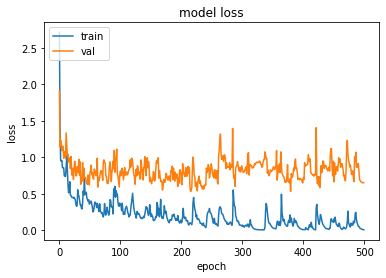

 Our result:- 
 [0 0 0 0 1 7 3 1 2 2 2 2 3 3 5 3 4 4 4 4 4 5 5 1 6 1 6 7 7 7 7]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.7741935483870968


In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.3)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=50,activation='tanh',trainable=True,return_sequences=True))
layers.append(tfKL.LSTM(units=100,activation='tanh',trainable=True))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy())

In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.3)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=160,activation='tanh',trainable=True))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy(Result,testSetY))

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 19s - loss: 25.9900 - accuracy: 0.3355 - val_loss: 7.0938 - val_accuracy: 0.4714
Epoch 2/500
31/31 - 5s - loss: 4.7866 - accuracy: 0.5980 - val_loss: 3.8556 - val_accuracy: 0.6000
Epoch 3/500
31/31 - 5s - loss: 3.3522 - accuracy: 0.6478 - val_loss: 3.0803 - val_accuracy: 0.7000
Epoch 4/500
31/31 - 5s - loss: 2.5467 - accuracy: 0.6877 - val_loss: 2.7235 - val_accuracy: 0.5714
Epoch 5/500
31/31 - 5s - loss: 2.7646 - accuracy: 0.6478 - val_loss: 3.2816 - val_accuracy: 0.7429
Epoch 6/500
31/31 - 5s - loss: 2.5843 - accuracy: 0.7176 - val_loss: 2.8359 - val_accuracy: 0.7286
Epoch 7/500
31/31 - 5s - loss: 2.4042 - accuracy: 0.7076 - val_loss: 2.6928 - val_accuracy: 0.6571
Epoch 8/500
31/31 - 5s - loss: 2.2694 - accuracy: 0.7043 - val_loss: 2.0735 - val_accuracy: 0.7000
Epoch 9/500
31/31 - 5s - loss: 2.1014 - accuracy: 0.7243 - val_loss: 2.6248 - val_accuracy: 0.7000
Epoch 10/500
31/31 - 5s - loss: 2.4672 - accu

In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=80,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.4)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=160,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.1)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy(Result,testSetY))